# fMRS first-level GLM dynamic fitting
## _Low temporal resolution demonstration_

fMRS contains repeated acquisitions of (single-voxel) MRS data which aim to record metabolite concentration changes that occur during neuronal activation. In MRS each spectrum must be 'fitted' to extract (relative) metabolite concentrations from the raw signal. To date, the repeated signal acquisitions in fMRS have been analysed independently without recourse to a model describing the dynamic changes. This typically requires spectra from multiple time-points to be averaged, as the SNR of each time-point is too low. In this work we propose instead to simultaneously fit a dynamic model (an fMRI-style GLM) and a spectral model (which explains the shape of the raw signal).

### In this notebook

This notebook will take you through the python code required to carry out fitting of a single subject's data. For this demo the number of time-points in the data has been reduced substantially, _8-fold_, from 64 to 8, to ensure fitting takes place quickly for demonstration purposes. The fitting is done using FSL-MRS's interactive python interface. The final cell shows you how to carry out the same fitting using the command-line interface, which is how the fitting of the full 64-point datasets is performed.

### What to do after this notebook

The core elements of this notebook are replicated for the full resolution data in the `first_level_fit.py` script. This can be run to generate the full results or you can used the pre-packaged results.

If you don't want to run the fitting yourself, you can just look at the data exploration / results notebook to see the results of the first level GLM fit, and how that is then used for a second-level group-analysis.

## Data

### Data description

The data takes the form of a single voxel (volume) MRS scan repeated 8 times, stored in the [NIfTI-MRS](https://github.com/wtclarke/mrs_nifti_standard) format. Four blocks of visual stimulation were administered during the scan to the subject and this was repeated twice: once with eyes open (stimulus experienced), once with eyes closed (hopefully no stimulus). The pattern of the stimulus was OFF-ON-OFF-ON. Each block was 64 s long for a total scan duration of 256 s, each data point represents 32 s of data. (The original TR was 4 s with 64 data points before averaging for this demo.)

### Data load and exploration

Using the FSL-MRS tools, load the eyes-open data and plot the 8 spectra.

The differences in fMRS signal between active and inactive time-points is small, don't expect to see much!

In [1]:
from fsl_mrs.utils import mrs_io
from fsl_mrs.utils import plotting as plot

# data variable represents a NIfTI-MRS file in memory
data = mrs_io.read_FID('simulated_data/low_res/lowres_stim.nii.gz')

# Plotly provides a nice interactive interface for data exploration
# The call to .mrs() provides a list of individual 'fittable' spectra objects
plot.plotly_dynMRS(data.mrs())

## Dynamic model

Here we are going to establish our dynamic model. This will attempt to explain the changes we expect to see in metabolite concentrations and other spectral properties as four blocks of visual stimulation (interleaved with blocks of 'rest') are administered to the subject.

The model will be established in two steps:
1. By defining an appropriate GLM design matrix which encodes the four blocks of stimulation, a linear drift regressor, and a constant (mean concentration) regressor.
2. A python configuration file which links the design matrix to the appropriate spectral fitting parameters (metabolite concentrations and linewidths).

### 1. Design matrix

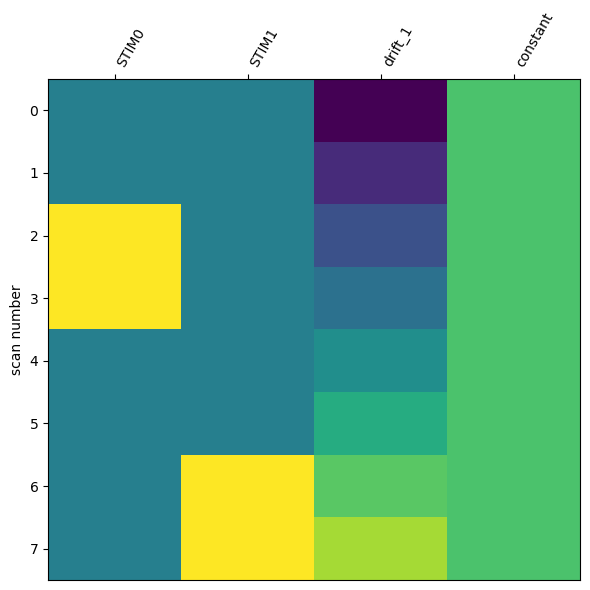

In [2]:
# We use the nilearn package + numpy + pandas to make the design matrix
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calculations to create the design matrix
tr          = 4.0 * 8  # repetition time * number of transients averaged for this demo
n_blocks    = 2  # Number of stimulation blocks
n_scans     = len(data.mrs()) # Total number of scan points (16)
frame_times = np.arange(n_scans) * tr  # Time point of each data point
conditions  = [f'STIM{i}' for i in range(n_blocks)] # each trial gets its own regressor
duration    = [2.*tr] * n_blocks # Duration of each stimulation block
onsets = [tr*1.+tr*4.*k for k in np.arange(0, n_blocks)] # Start time of each stimulation block.
events = pd.DataFrame({'trial_type': conditions, 
                       'onset'     : onsets,
                       'duration'  : duration})

# Pass to nilearn function to create design matrix
design_matrix = make_first_level_design_matrix(
    frame_times,
    events,
    drift_model='polynomial',
    drift_order=1, 
    hrf_model='glover') 

# Plot the designmatrix for inspection
fig = plt.figure(figsize=(6,6))
_ = plot_design_matrix(design_matrix, ax=fig.gca())

### 2. Configuration file
Next we make a FSL-MRS dynamic fitting configuration file. This takes the format of a small block of python code in a separate file.

In it we link spectral model parameters (concentrations, linewidth/shapes, frequency shifts, baseline, and phase), to the dynamic model through functions we define in the file (here: model_glm). We can also apply bounds on the fitted parameters, and finally we must provide the gradient of the dynamic model functions for the optimiser.

The below file can be read as follows:
1. The metabolite scaling (concentrations, _conc_) will be fitted according to the design matrix we created above.
2. There are two linewidth parameters: _gamma_ (for lorentzian, T2 broadening), and _sigma_ (for Gaussian, T2* broadening). The former is constant (_fixed_) across all time points, but the latter is expected to vary and is also fit using the GLM function. The blocks of visual stimulus will cause a BOLD response that increases T2* and lowers linewidths.
3. All other parmaeters: frequency shifts (_eps_), polynomial baseline (_baseline_), and 0th and 1st order phase (_Phi_0_, _Phi_1_) are constant (_fixed_) across time points.
4. Bounds limit the lorentzian linewidth parameter _gamma_ and the constant terms of the GLM fitted parameters to positive values.
5. We define the forward dynamic model function (_model_glm_) and the gradient (_model_glm_grad_).

In [3]:
%%writefile fmrs_model_low_res.py

# Parameter - functional relationships
Parameters = {
'conc'     : {'dynamic':'model_glm','params':[f'beta{i}' for i in range(4)]},
'gamma'    : 'fixed',
'sigma'    : {'dynamic':'model_glm','params':[f'beta{i}' for i in range(4)]},
'eps'      : 'fixed',
'baseline' : 'fixed',
'Phi_0'    : 'fixed',
'Phi_1'    : 'fixed'
}

# Bounds on free fitted parameters
Bounds = {
'gamma' : (0,None),
'beta3' : (0,None),
}

# Dynamic models
from numpy import dot
def model_glm(p,t):
    return dot(t,p)

# Dynamic model gradients
def model_glm_grad(p,t):
    return t.T


Overwriting fmrs_model_low_res.py


## Spectral model

Above we have defined the dynamic part of the model. Now we need to handle the spectral model. This also requires two things:
1. A set of basis spectra
2. FSL-MRS fitting parameters.

A brief description of the spectral model parameters are given here, but for much more information see the [quick start guide and online practical](https://open.win.ox.ac.uk/pages/fsl/fsl_mrs/quick_start.html) for the FSL-MRS toolbox.

### 1. Basis spectra
FSL-MRS is a linear combination fitting tool. That means that the MRS signal is modelled (and concentrations estimated) using a linear combination of scaled and broadened signals of each metabolite expected to be present. (See our [video introduction to fitting](https://youtu.be/tLJG28Gs_xE) for more info.) We therefore need a set of 'basis' signals (i.e. fingerprints) for each metabolite.

Here we load an quickly inspect the contents of the included basis set using the FSL tools. We remove a few basis spectra from the list to speed up the optimisation in this demo. The removed spectra are metabolites we don't expect to be present in high concentrations.

Once plotted you can see 15 metabolite spectra and an empirically measured macromolecule spectrum (Mac).

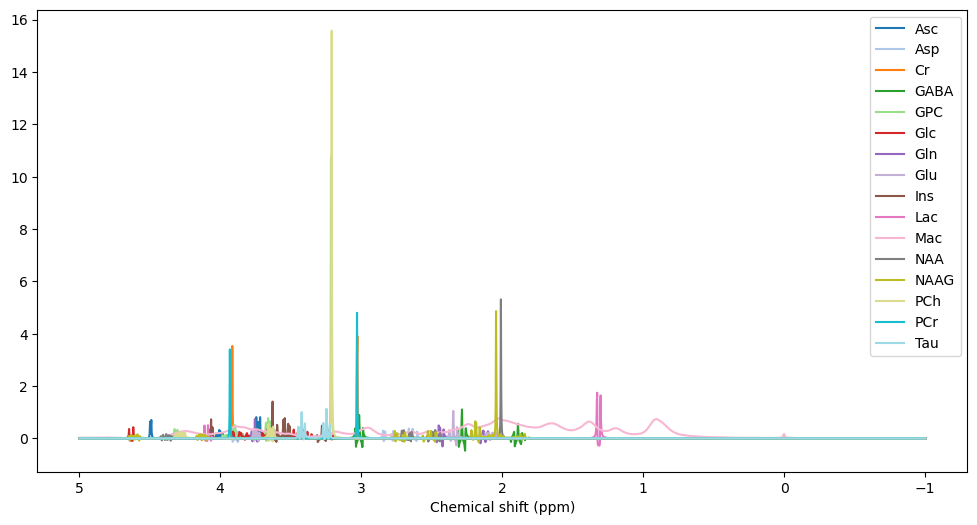

In [12]:
basis = mrs_io.read_basis('basis')

basis.remove_fid_from_basis('PE')
basis.remove_fid_from_basis('Scyllo')
basis.remove_fid_from_basis('GSH')


fig = plt.figure(figsize=(12,6))
_=basis.plot(ppmlim=(-1, 5))

We will use this basis set for the fitting. Each of the metabolites seen here will be constrained using the dynamic GLM we defined above.

The next cell creates a list of 'fittable' MRS object each loaded with a description of the basis set

In [13]:
# Load the basis set into list of MRS objects
mrslist = data.mrs(basis=basis)

### 2. Spectral fitting parameters

Now we need to set a few parameters on the spectral fitting model. FSL-MRS uses a relatively low parameter model by default; all the metabolite frequency shifts and lineshapes are assumed to be the same unless specified. Here we know that isn't the case, the _Mac_ signal must be separately shifted and broadened.

We set the following parameters:
1. The Mac basis spectrum is treated independently of others.
2. We set a low order (0th order) polynomial baseline
3. We set the default optimisation region (0.2 to 4.2 ppm).

In [14]:
Fitargs = {
    'metab_groups'   : mrslist[0].parse_metab_groups('Mac'),
    'baseline_order' : 0,
    'ppmlim'         : (.2, 4.2)}


We can quickly check that this choice of spectral fitting parameters gives a sensible result fitting one data point

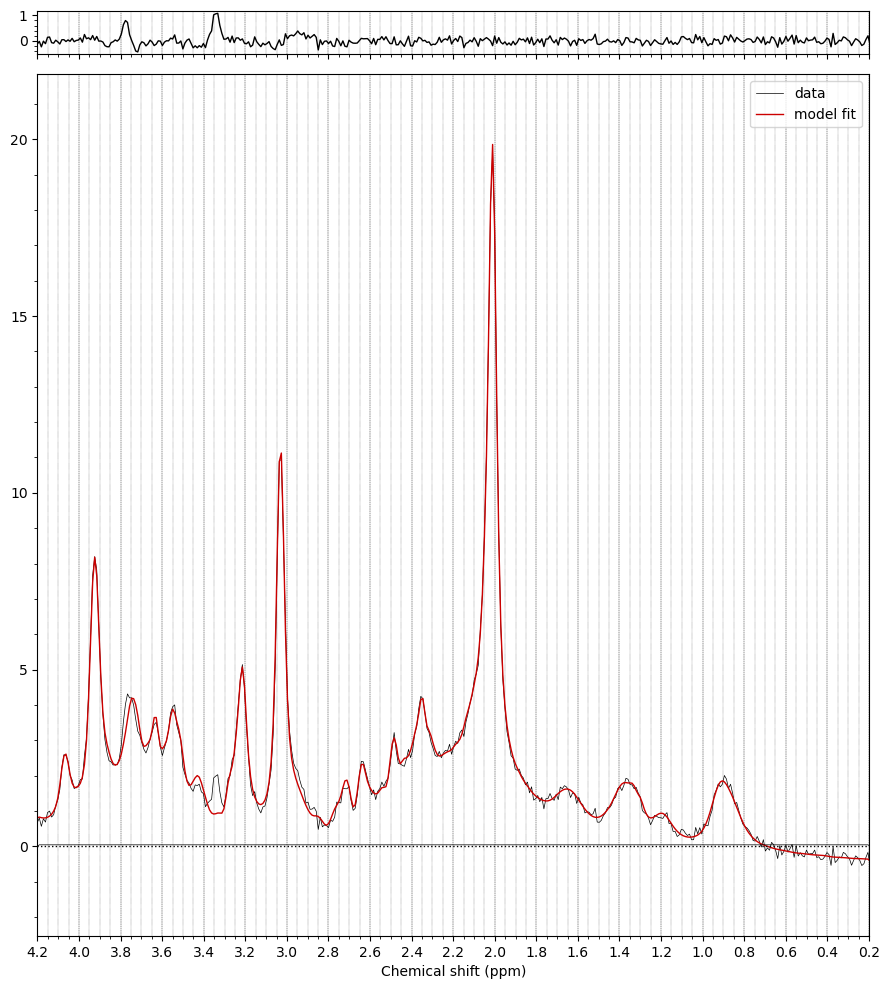

In [19]:
# Ignore a rank warning arising from the small bandwidth of this data.
import warnings
warnings.filterwarnings('ignore')

test_result = mrslist[0].fit(**Fitargs)
_ = test_result.plot(mrslist[0])

The above looks fine. There are some structured residuals from our deliberate decision to exclude some metabolites (to speed things up).

## Dynamic Fitting

We now move on to the joint spectral-temporal fitting stage. First we create a FSL-MRS dynMRS class object, this class manages the dynamic fitting.

In [16]:
from fsl_mrs.dynamic import dynMRS

dyn = dynMRS(
    mrslist,
    design_matrix.to_numpy(),
    config_file= 'fmrs_model_low_res.py',
    **Fitargs)


We now make a call to the fitting. This is done here in two steps to illustrate that there is an initialisation step before a main optimisation step.

The initialisation step fits each spectrum completely independently before inverting the dynamic model to provide an initialisation to the main optimisation.

This step can take some time to run, but will depend on computing power.

In [20]:
init = dyn.initialise(verbose=True)
dyn_res = dyn.fit(init=init, verbose=True)

# Alternatively the above could be carried out in a single line by running the following line.
# Initialisation is automatically run if not passed explicitly
# dyn_res = dyn.fit(verbose=True)

Init done in 9.162115097045898 seconds.
Start fitting
...completed in 7.0722832679748535 seconds.
Collect results
...completed in 0.9062867164611816 seconds.


## Fit visualisation

We can plot the fits of each spectrum.

In [28]:
fig = dyn_res.plot_spectra(tvals=['REST', 'REST', 'STIM', 'STIM'] * 2)
fig.update_layout(
    width=1000,
    height=900)

We can also the view of the fitted parameters mapped back to a per-spectrum representation.  
Here we see some key results that will hopefully be borne out in the later statistical analysis:
1. That we see the predicted linewidth decrease. The sigma_0 parameter, the Gaussian broadening associated with all the metabolite peaks, shows a decrease in each stimulation block
2. That glutamate shows an increase in each activation block.

However, this is a single subject's data and we are trying to find changes at the ~1-5% level with uncertainty of the same order of magnitude.

__Note that the orange line (dynamic) is not a fit to the blue dots (independent fitting results)__. However for easily estimated parameters (e.g. NAA) we expect close correspondence.

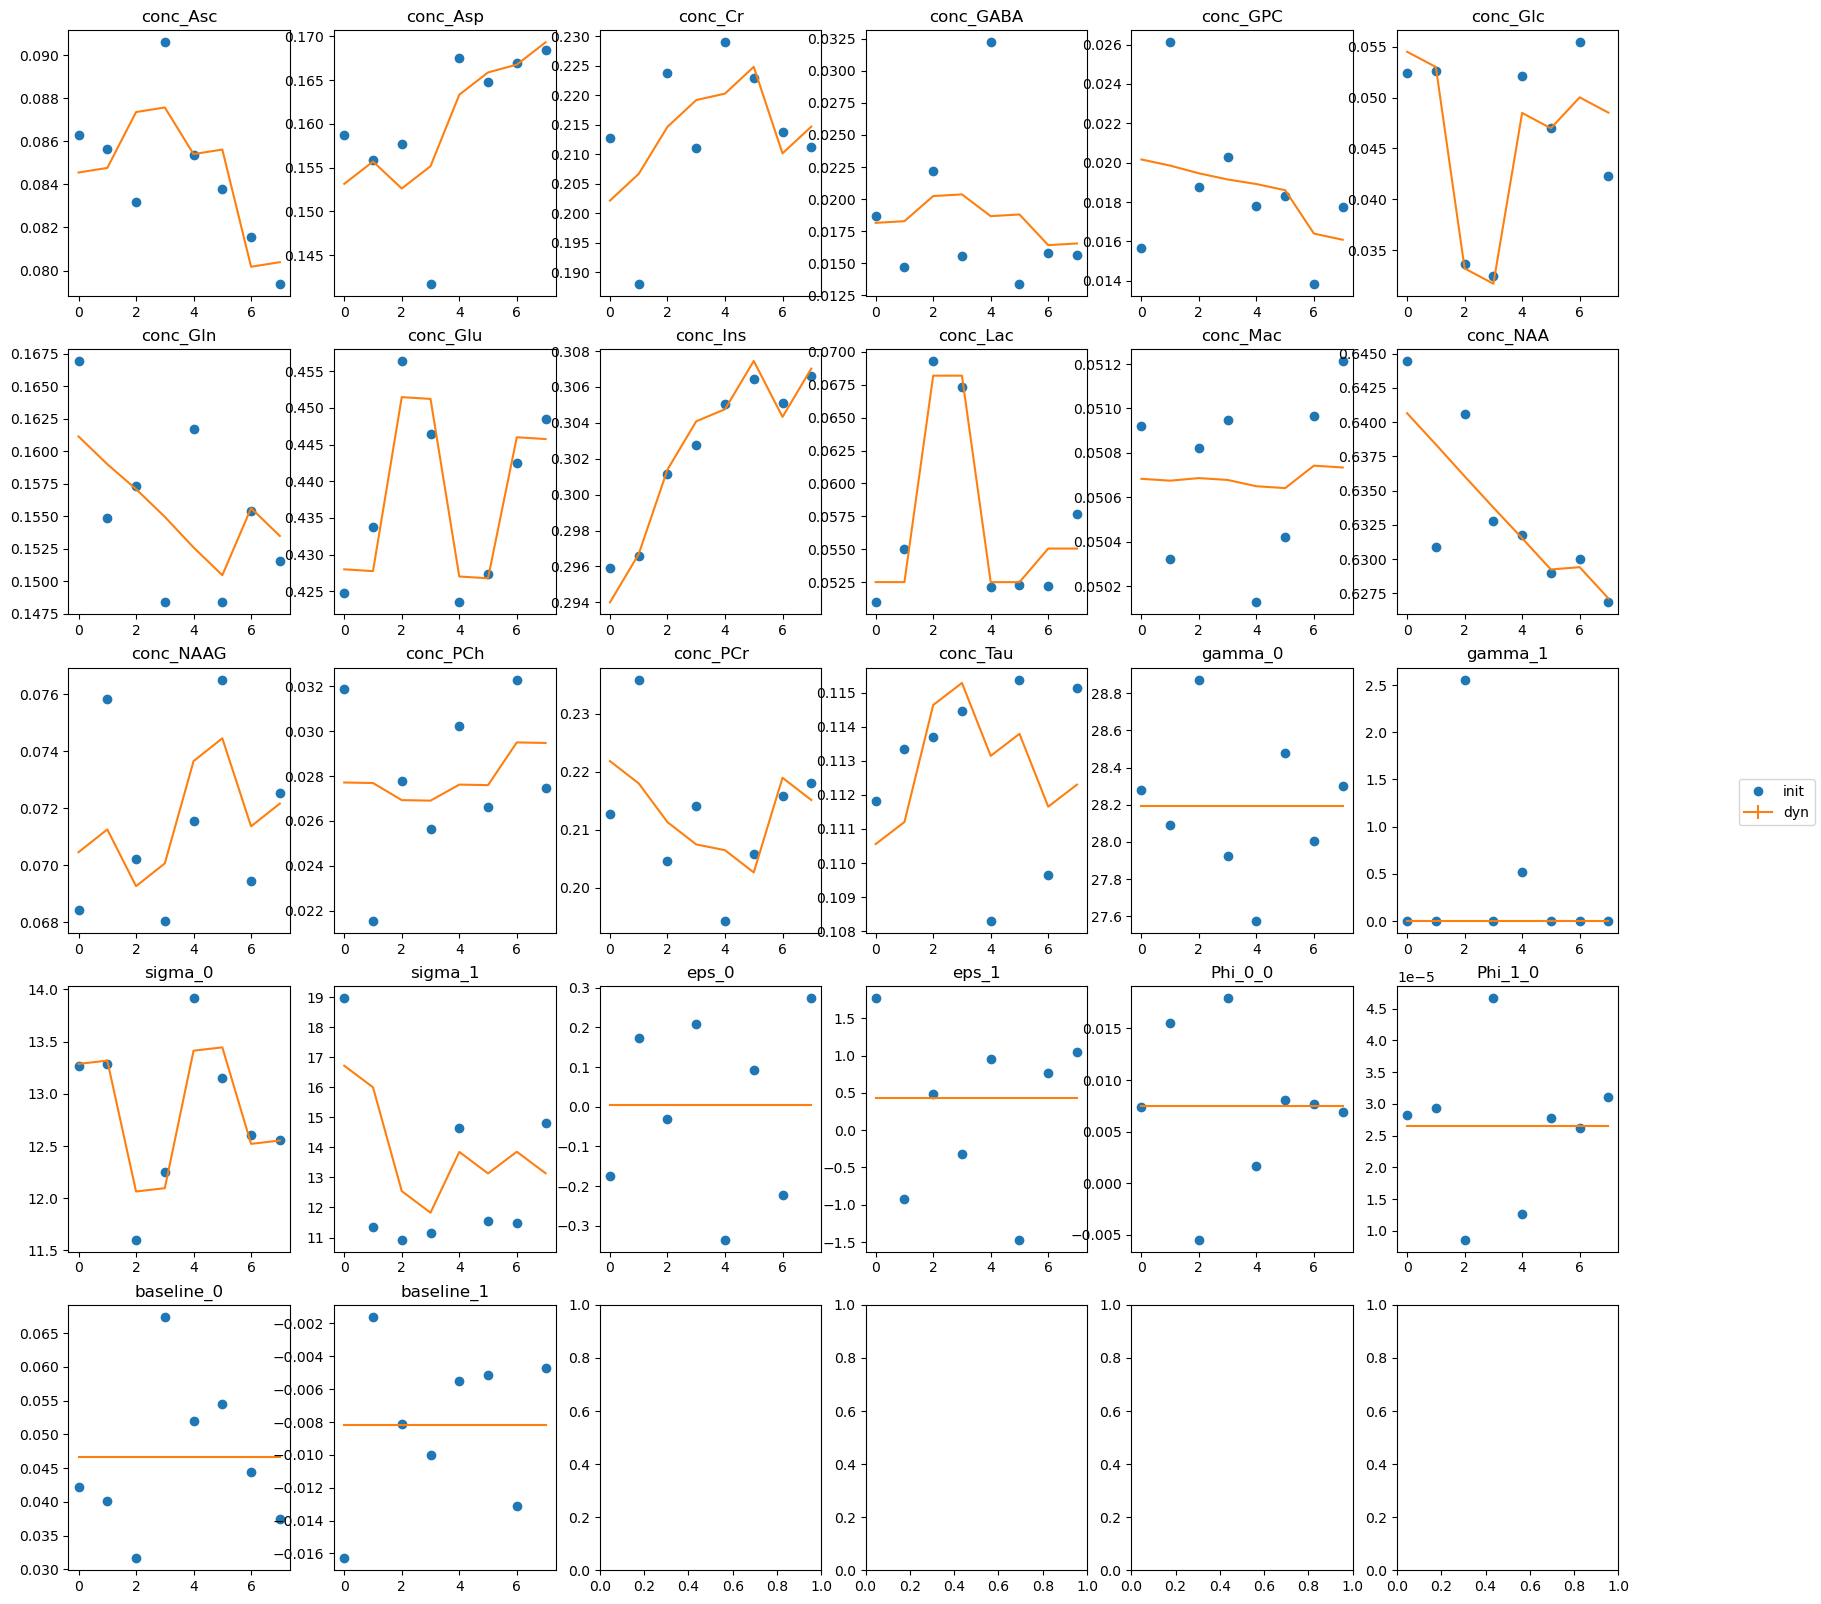

In [29]:
_ = dyn_res.plot_mapped(tvals=np.arange(8))

## Results output

We can access the raw results as pandas dataframes (table). Here we combine the point estimates and standard deviation (SD) of each fitted parameter into a single dataframe.

In [30]:
pd.concat((dyn_res.mean_free, dyn_res.std_free), axis=1, keys=['mean', 'sd'])

,mean,sd
conc_Asc_beta0,0.002381,0.007676
conc_Asc_beta1,-0.005660,0.009601
conc_Asc_beta2,0.001496,0.010444
conc_Asc_beta3,0.085302,0.004713
conc_Asp_beta0,-0.005615,0.014003
...,...,...
eps_1,0.436788,0.104960
Phi_0_0,0.007475,0.004045
Phi_1_0,0.000027,0.000006
baseline_0,0.046715,0.006916


Or produce an easier to read summary:

In [31]:
dyn_res.collected_results()['conc']

,beta0,beta1,beta2,beta3
metabolite,,,,
Asc,0.002381,-0.005660,0.001496,0.085302
Asp,-0.005615,-0.001653,0.017801,0.162045
Cr,0.003440,-0.019195,0.031729,0.218016
GABA,0.001825,-0.002520,0.000914,0.018606
GPC,-0.000078,-0.001891,-0.002186,0.019071
Glc,-0.018286,0.004541,-0.010527,0.049234
Gln,0.000218,0.007291,-0.014947,0.153679
Glu,0.023977,0.019481,-0.001711,0.427122
Ins,0.002017,-0.005803,0.018818,0.303410


Finally we can also save the results object to csv format.

In [32]:
dyn_res.save('low_res_example')

## Command-line interface

This notebook has used the interactive python api of FSL-MRS to carry out the fitting. The same process can be accessed from the command line using a pre-assembled script _fsl_dynmrs_.

In [33]:
%sx fsl_dynmrs --help

['usage: fsl_dynmrs [-h] [-v] --data <FILE> --basis <FILE> --output <str>',
 '                  --dyn_config <FILE> --time_variables <FILE> [<FILE> ...]',
 '                  [--ppmlim LOW HIGH] [--h2o H2O] [--baseline_order ORDER]',
 '                  [--metab_groups METAB_GROUPS [METAB_GROUPS ...]]',
 '                  [--lorentzian] [--t1 IMAGE] [--report] [--verbose]',
 '                  [--overwrite] [--no_rescale] [--config CONFIG]',
 '',
 'FSL Dynamic Magnetic Resonance Spectroscopy Wrapper Script',
 '',
 'optional arguments:',
 '  -h, --help            show this help message and exit',
 "  -v, --version         show program's version number and exit",
 '',
 'required arguments:',
 '  --data <FILE>         input NIfTI-MRS file (should be 5D NIFTI)',
 '  --basis <FILE>        Basis folder containing basis spectra',
 '  --output <str>        output folder',
 '  --dyn_config <FILE>   configuration file for dynamic fitting',
 '  --time_variables <FILE> [<FILE> ...]',
 '          

A cell below performs the same fitting using this command line interface. First we must save the design matrix to a file which will be read by the command line script.

We also save the reduced list of basis spectra to match the above processing.

In [34]:
design_matrix.to_csv('low_res_dmat.csv', index=False, header=False)

basis.save('low_res_basis')

Run the command line script.

In [35]:
%%bash

fsl_dynmrs \
    --data simulated_data/low_res/lowres_stim.nii.gz \
    --basis low_res_basis \
    --dyn_config fmrs_model_low_res.py \
    --time_variables low_res_dmat.csv \
    --baseline_order 0 \
    --metab_groups Mac \
    --output low_res_example_cmd \
    --report \
    --overwrite

## Conclusion

This notebook has demonstrated how you can carry out a GLM fit of single voxel fMRS data. The demonstration was done an a deliberately reduced resolution piece of data. The elements of this notebook, particularly the command line implementation are replicated in the `first_level_fit.py` script that will carry out the fit on all 13 subject's 128-time point data. You can take a look at that script (and the interactive notebook `full_fit_setup.ipynb` which creates a full sized design matrix) to see how the fit is done. Note that running it on a single machine will take a while and that it has optional components for cluster job submission.

If you'd like to skip to the generation and interpretation of the group-level analysis then run the `group_analysis.ipynb` file.